# Exploring Migration Data from the MapIneq API

This notebook demonstrates how to access, filter, and visualize international migration data using the **MapIneq API** — a European research initiative focused on mapping inequalities across life domains and geographies.

Specifically, we will:

- Connect to the **MapIneq API** and query the `meta_migration_in` dataset, sourced from Meta's Data for Good program.
- Explore available structural and dataset-specific filters (e.g., time, region level, origin country, month).
- Retrieve migration data at the **NUTS-0 (country)** level for a selected year and apply filters.
- Join the resulting data with official **NUTS region geometry** for mapping.
- Visualize the results using both:
  - 📉 **Seaborn + GeoPandas** for static choropleth maps
  - 🗺️ **Folium** for interactive web maps

The goal is to show how easy it is to integrate the MapIneq API into your research or data workflow — enabling reproducible and scalable analyses of spatial inequality.

> 📎 For more about the MapIneq project, visit: [https://mapineq.eu](https://www.mapineq.org/)  
> 📎 API documentation: [https://docs.mapineq.org](https://docs.mapineq.org)


In [2]:
# Required for API queries
import json
import requests

# Required for data wrangling
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

BASE = "https://api.mapineq.org"

# Find Data by NUTS Region (`get_source_by_nuts_level`)

MapIneq offers several ways to access its data via the public API, as outlined in the official documentation:  
🔗 https://docs.mapineq.org/api_tutorial_python

In this section, we’ll demonstrate how to use the first method: **"Find Data by NUTS Region"**.

This example will walk you through the entire process — from querying the API to integrating the retrieved data into your own research workflow.


## Query Data by NUTS Region (get_source_by_nuts_level)

In [3]:
# Define the base API URL
BASE = "https://api.mapineq.org"

# Identify the endpoint for querying data by NUTS level
endpoint = "functions/postgisftw.get_source_by_nuts_level/items.json"

# Set query parameters:
# - _level: NUTS level (0 = country, 1 = major region, 2 = intermediate, 3 = small regions)
# - limit: maximum number of records to return
params = {
    "_level": 0,
    "limit": 1000
}

In [4]:
# Make the GET request
response = requests.get(f"{BASE}/{endpoint}", params=params)

# Check the response status
if response.status_code == 200:
    print("✅ Request successful")
else:
    raise Exception(f"❌ Request failed with status code {response.status_code}")

# Parse the JSON response
data = response.json()
data[:5]

✅ Request successful


[{'f_description': 'Academic Budget by, year, NUTS 1, NUTS 2 and NUTS 3 regions. Data collected by the European Higher Education Sector Observatory. (EHESO)',
  'f_resource': 'eheso_budgetclass',
  'f_short_description': 'Acad. Budget'},
 {'f_description': 'Academic Expenditure by, year, NUTS 1, NUTS 2 and NUTS 3 regions. Data collected by the European Higher Education Sector Observatory. (EHESO)',
  'f_resource': 'eheso_expendclass',
  'f_short_description': 'Acad. Expenditure'},
 {'f_description': 'Academic Funding by, year, NUTS 1, NUTS 2 and NUTS 3 regions. Data collected by the European Higher Education Sector Observatory. (EHESO)',
  'f_resource': 'eheso_fundingclass',
  'f_short_description': 'Acad. Funding'},
 {'f_description': 'Academic Graduates by year, citizenship, level, gender, field, NUTS 1, NUTS 2 and NUTS 3 regions. Data collected by the European Higher Education Sector Observatory. (EHESO)',
  'f_resource': 'eheso_graduates',
  'f_short_description': 'Acad. Graduates'

We received the data in JSON format, but it's not very easy to read as-is.

To make it more readable and easier to work with, we'll convert it into a pandas DataFrame.  
This will allow us to explore the dataset in a more structured and straightforward way.

In [5]:
# Extract the 'data' field (contains actual records)
df_content = pd.DataFrame(data)

# Display the resulting DataFrame
df_content

,f_description,f_resource,f_short_description
0,"Academic Budget by, year, NUTS 1, NUTS 2 and N...",eheso_budgetclass,Acad. Budget
1,"Academic Expenditure by, year, NUTS 1, NUTS 2 ...",eheso_expendclass,Acad. Expenditure
2,"Academic Funding by, year, NUTS 1, NUTS 2 and ...",eheso_fundingclass,Acad. Funding
3,"Academic Graduates by year, citizenship, level...",eheso_graduates,Acad. Graduates
4,"Acquisition of citizenship by age group, sex a...",MIGR_ACQ1CTZ,New citizenship
...,...,...,...
684,"Youth self-employment by sex, age and educatio...",YTH_EMPL_040,Youth self-employed
685,"Youth unemployment by sex, age and educational...",YTH_EMPL_090,Youth employment
686,"Youth unemployment rate by sex, age and countr...",YTH_EMPL_100,Youth employment
687,"Youth unemployment rate by sex, age and NUTS 2...",YTH_EMPL_110,Youth employment


## Choose the dataset

Today, we’ll demonstrate how to access and explore the **Migration dataset from Meta** via the MapIneq API.

This is a newly available dataset that summarizes international migration flows between countries, based on de-identified user data from Meta platforms (e.g., Facebook).

### 🌍 About the Meta Migration Dataset:
- **Name**: International Migration Flows
- **Source**: Meta (Facebook) Data for Good program  
  🔗 https://data.humdata.org/dataset/international-migration-flows  
- **What it contains**: Aggregated estimates of international migration flows between origin and destination countries over time
- **Geographic level**: NUTS 0 (country-level)
- **Temporal coverage**: 2019-2022, Monthly

Below is a snapshot of how the selected dataset appears in the [MapIneq Link dashboard](https://mapineq.eu/mapineqlink_v2_0/):

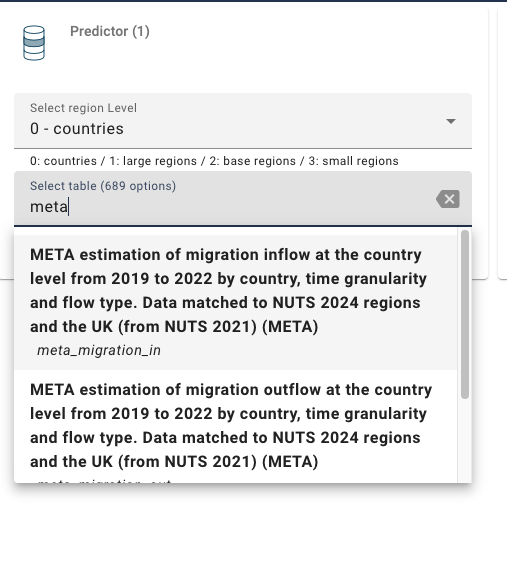

This dashboard lets users visually explore and compare spatial patterns of inequality across Europe, filtered by dataset, region, and time.

Here, we’re demonstrating how to access the **same dataset programmatically via the API**, so you can bring it directly into your own analysis.

In [6]:
# 🔍 Filter available datasets to find those provided by Meta
# We search for 'meta' in the 'f_description' field (case-insensitive)
meta_datasets = df_content[df_content['f_description'].str.contains('meta', case=False, na=False)]

# Display matching datasets
meta_datasets

,f_description,f_resource,f_short_description
328,META estimation of migration inflow at the cou...,meta_migration_in,META Migration In
329,META estimation of migration outflow at the co...,meta_migration_out,META Migration Out
597,Social Connected Index (SCI) provided by Meta ...,meta_sci_cntry,META SCI


In [7]:
# # 🔍 Alternatively, search for survey datasets from Eurostat
# # We filter based on the 'f_description' field containing 'Estat'
# eurostat_datasets = df_content[df_content['f_description'].str.contains('Estat', case=False, na=False)]

# # Display matching datasets
# eurostat_datasets

### Select the Dataset (Resource)

Now that we've browsed the available datasets, we can choose the specific one we want to work with.

For this example, we’ll use the `meta_migration_in` dataset, which tracks **incoming international migration** based on Meta data.

Other related options include:

- `meta_migration_out`: for outgoing migration


In [8]:
#  Select the dataset (resource) to use in the next API query

RESOURCE = "meta_migration_in"      # number of people arriving in a country
# RESOURCE = "meta_migration_out"     # number of people leaving a country
# RESOURCE = "meta_sci_cntry"

# RESOURCE = "TGS00103"

## Structural Filters

Each dataset available via the MapIneq API follows a consistent structure of required **structural filters**.  
These filters must be specified in order to successfully query data from any dataset.


### Check Available Structural Filters

Before fetching actual data, we need to check available structural filters for the selected dataset (`meta_migration_in`).

We use the API endpoint:

In [9]:
# Query the API for time and geographic coverage of the selected resource
resp = requests.get(
    f"{BASE}/functions/postgisftw.get_year_nuts_level_from_source/items.json",
    params={"_resource": RESOURCE},
    timeout=60
)

# Raise an error if the request fails
resp.raise_for_status()

# Convert JSON response to DataFrame
coverage = pd.DataFrame(resp.json())
coverage

,f_level,f_year
0,0,2019
1,0,2020
2,0,2021
3,0,2022


Common structural filters include:

- 🌍 **Region Level** (NUTS level: 0, 1, 2, or 3)  
  ✔️ Already selected above when we queried data by region level

- 🗂️ **Table / Dataset** (e.g., `meta_migration`, `estat`, etc.)  
  ✔️ Also selected above based on the dataset of interest

- 📆 **Time** (e.g., year or month)  
  ⏳ **This will be defined here**

These filters are **mandatory**, though the available options can vary depending on the dataset you're working with.

Below is an example of how these filters appear in the MapIneq dashboard interface:

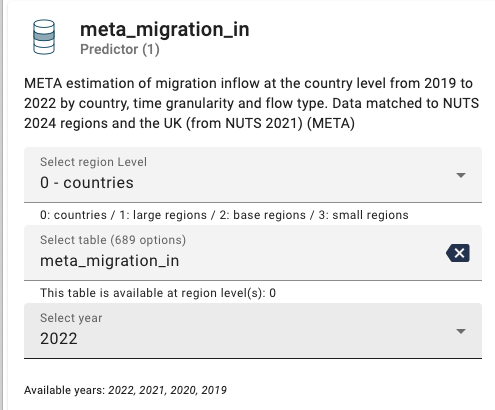


### Set Structural Filters

In [10]:
# Pick the most recent year + lowest level (0 = country)
year = int(coverage["f_year"].max())
level = int(coverage["f_level"].min())

print(f"Using year={year}, level={level}")

Using year=2022, level=0


## Attributes of the Dataset

In addition to structural filters like region and time, each dataset comes with its own **specific attributes**.  
These are also required when querying data and depend on the dataset you've selected.

For example, attributes may include:

- Gender / Sex
- Age group
- Country of origin / destination
- Education level
- Other thematic dimensions

These attribute options are **dataset-specific**, so you’ll need to inspect them *after* choosing a dataset in order to see what’s available.

We’ll use the following API endpoint: 
    
`/functions/postgisftw.get_column_values_source_json/items.json`  

This tells us what filter values are available for the current selection.

In [11]:
# 🎯 Define the structural filters to pass to the attribute query
# Replace `year` and `level` with values from the earlier 'coverage' DataFrame
sel = {
    "year": str(year),      # e.g. "2022"
    "level": str(level),    # e.g. "0" (for country-level)
    "selected": []          # empty because we want to discover available filters, not apply any yet
}

# Query the API for dataset-specific attribute filters
resp = requests.get(
    f"{BASE}/functions/postgisftw.get_column_values_source_json/items.json",
    params={
        "_resource": RESOURCE,
        "source_selections": json.dumps(sel)  # must be passed as a JSON string
    },
    timeout=60
)

# Raise error if request fails
resp.raise_for_status()

# Convert the response to a DataFrame for easier viewing
filters = pd.DataFrame(resp.json())
filters

,field,field_label,field_values
0,origin,origin,"[{'label': 'All countries', 'value': 'All coun..."
1,month,month,"[{'label': 'January', 'value': 'January'}, {'l..."


### View Available Options for an Attribute

To see all available values for a specific attribute (e.g. `month`), we extract the `field_values` from the filter list and convert it into a readable table.

In [12]:
# Extract 'field_values' for the 'month' attribute
month_options = filters.loc[filters['field'] == 'month', 'field_values'].values[0]

# Display all available options
pd.DataFrame(month_options)

,label,value
0,January,January
1,February,February
2,March,March
3,April,April
4,May,May
5,June,June
6,July,July
7,August,August
8,September,September
9,October,October


### Query the Dataset with Selected Filters

Now that we've selected the structural filters (`year`, `region level`) and dataset-specific filters (`origin`, `month`), we can query the actual data.

In this example, we are retrieving:
- Migration **into** a country (`meta_migration_in`)
- From **origin = UK**
- For the month of **January**
- At the selected **NUTS level** and **year**

This returns a table with values that can now be analyzed, visualized, or saved for your research.

In [13]:
# Define the filter conditions for the dataset
conditions = [
    # {"field": "origin", "value": "UK"},         # Country of origin
    {"field": "origin", "value": "All countries"},         # Country of origin
    {"field": "month", "value": "January"}      # Month (or set to None to include all months)
]

# Payload to pass into the query
payload = {
    "source": RESOURCE,
    "conditions": conditions
}

# Make the request to retrieve data
resp = requests.get(
    f"{BASE}/functions/postgisftw.get_x_data/items.json",
    params={
        "_level": level,
        "_year": year,
        "X_JSON": json.dumps(payload),
        "limit": 5000
    },
    timeout=60
)

# Raise error if request fails
resp.raise_for_status()

# Convert the result into a DataFrame
df = pd.DataFrame(resp.json())
df

,data_year,geo,geo_name,geo_source,geo_year,x
0,2022,AL,Shqip�ria,NUTS,2024,2481.0
1,2022,AT,�sterreich,NUTS,2024,9230.0
2,2022,BE,Belgique/Belgi�,NUTS,2024,10452.0
3,2022,BG,Bulgaria,NUTS,2024,5116.0
4,2022,CH,Schweiz/Suisse/Svizzera,NUTS,2024,10225.0
5,2022,CY,K�pros,NUTS,2024,6113.0
6,2022,CZ,?esko,NUTS,2024,8256.0
7,2022,DE,Deutschland,NUTS,2024,64675.0
8,2022,DK,Danmark,NUTS,2024,3931.0
9,2022,EE,Eesti,NUTS,2024,1846.0


## Match with Geometry Data

To create maps or spatial visualizations, you need to join the dataset with official **NUTS region geometries** (shapefiles).

You can download the latest NUTS boundaries from the official Eurostat GISCO website:

🔗 [EUROSTAT NUTS Boundaries](https://ec.europa.eu/eurostat/web/gisco/geodata/statistical-units/territorial-units-statistics)

Once downloaded, you can use libraries like `geopandas` to load and merge the shapefile with your dataset using the NUTS region codes.

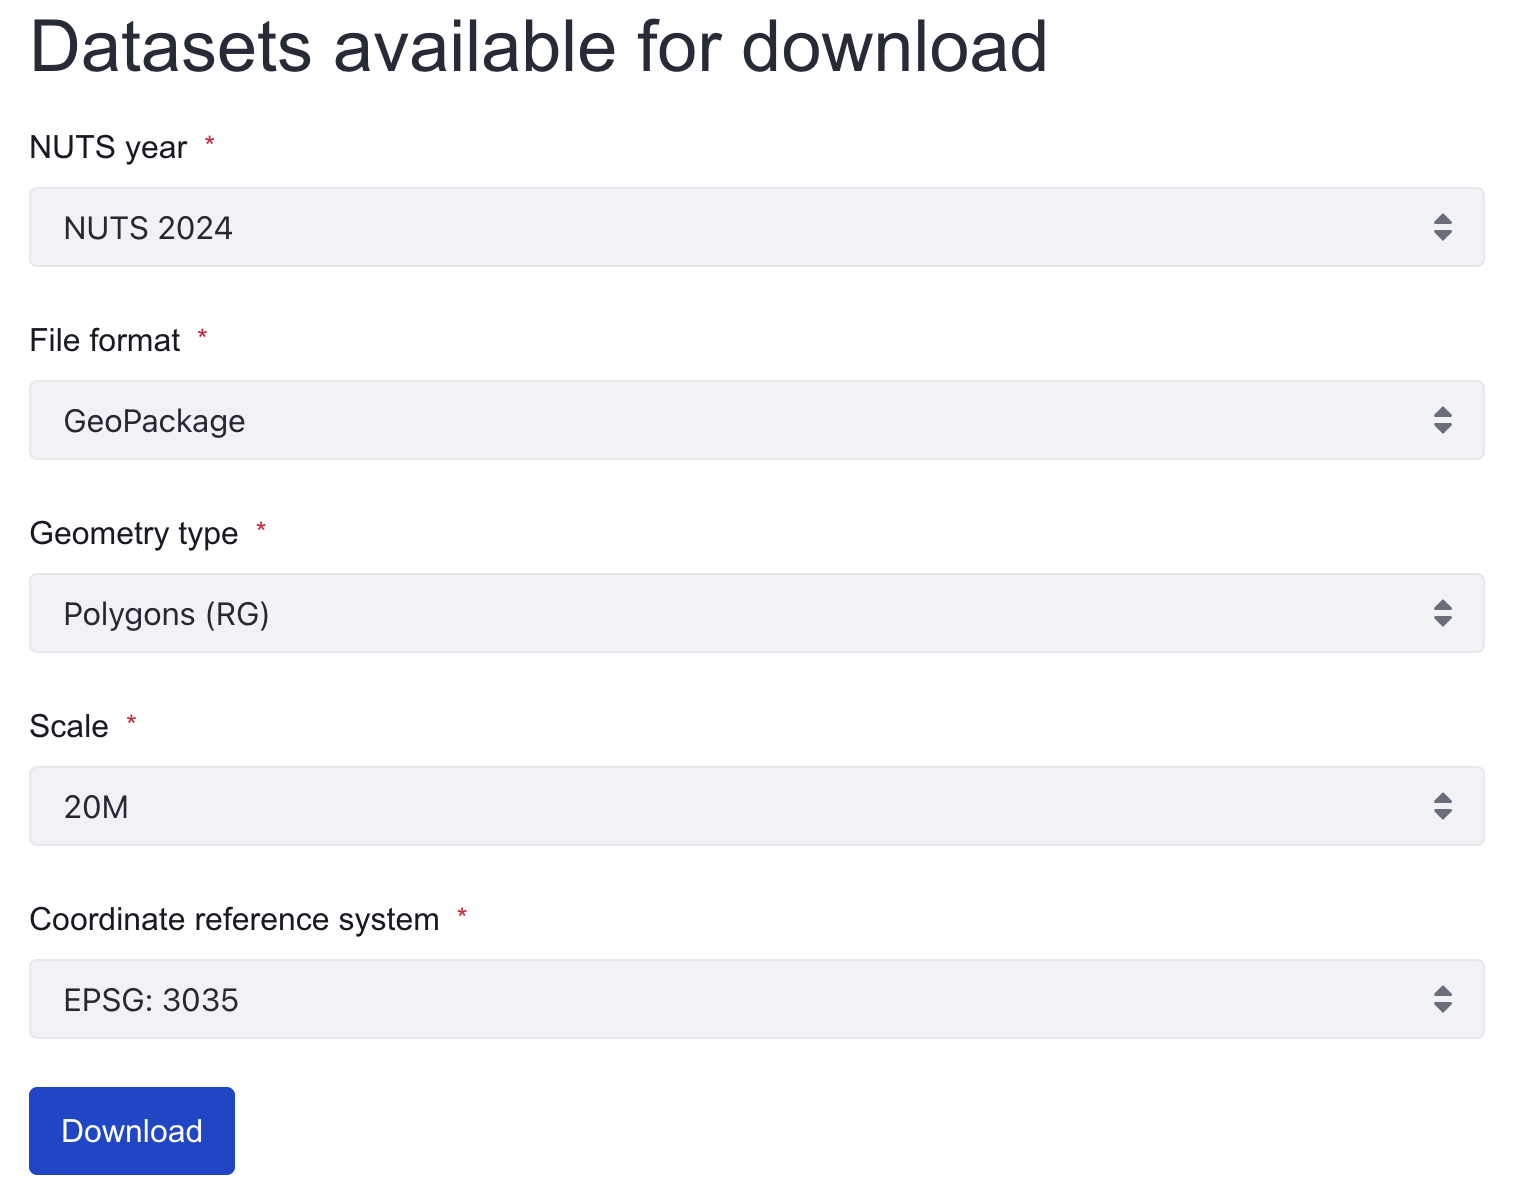

In [28]:
# Read in the NUTS GeoPackage
gdf_nuts = gpd.read_file("/Users/wenlanzhang/Downloads/NUTS_RG_20M_2021_3035.gpkg")
gdf_nuts = gdf_nuts[['NUTS_ID', 'geometry']]

gdf_nuts

gdf_nuts

,NUTS_ID,geometry
0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961..."
1,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483..."
2,HU,"POLYGON ((5160506.845 2894264.902, 5175139.635..."
3,AL,"POLYGON ((5119512.292 2221331.401, 5129579.17 ..."
4,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
...,...,...
2005,TRC21,"POLYGON ((6904684.585 2120354.802, 6938677.828..."
2006,TRC22,"POLYGON ((6976739.977 2288886.707, 6989716.598..."
2007,NO0B2,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."
2008,NO0B,"MULTIPOLYGON (((4754167.335 6382461.409, 47465..."


In [30]:
# Adjust column names as needed
merged = gdf_nuts.merge(df, left_on="NUTS_ID", right_on="geo")
merged

,NUTS_ID,geometry,data_year,geo,geo_name,geo_source,geo_year,x
0,FR,"MULTIPOLYGON (((9954236.116 -3059379.316, 9961...",2022,FR,France,NUTS,2024,46255.0
1,HR,"MULTIPOLYGON (((4827385.889 2618351.326, 48483...",2022,HR,Hrvatska,NUTS,2024,2848.0
2,HU,"POLYGON ((5160506.845 2894264.902, 5175139.635...",2022,HU,Magyarorsz�g,NUTS,2024,4626.0
3,AL,"POLYGON ((5119512.292 2221331.401, 5129579.17 ...",2022,AL,Shqip�ria,NUTS,2024,2481.0
4,AT,"POLYGON ((4742889.368 2876362.725, 4783217.798...",2022,AT,�sterreich,NUTS,2024,9230.0
5,BE,"POLYGON ((3957506.818 3167694.476, 3964175.126...",2022,BE,Belgique/Belgi�,NUTS,2024,10452.0
6,BG,"POLYGON ((5351090.421 2396045.312, 5363358.686...",2022,BG,Bulgaria,NUTS,2024,5116.0
7,CH,"POLYGON ((4221123.476 2731035.919, 4230514.931...",2022,CH,Schweiz/Suisse/Svizzera,NUTS,2024,10225.0
8,CY,"POLYGON ((6342668.882 1629618.498, 6342926.802...",2022,CY,K�pros,NUTS,2024,6113.0
9,CZ,"POLYGON ((4645979.16 3093185.023, 4656689.778 ...",2022,CZ,?esko,NUTS,2024,8256.0


### Static Choropleth Map with `Seaborn` & `GeoPandas`

This plot shows a **static choropleth map** of incoming international migration at the NUTS-0 (country) level, using Meta’s migration dataset.

We use `GeoPandas` to plot geometries and `Seaborn` to style the visual, with custom map bounds for better framing.

Key features:
- Colored by number of incoming migrants (`x`)
- Custom axis limits to focus on Europe
- Legend and title included

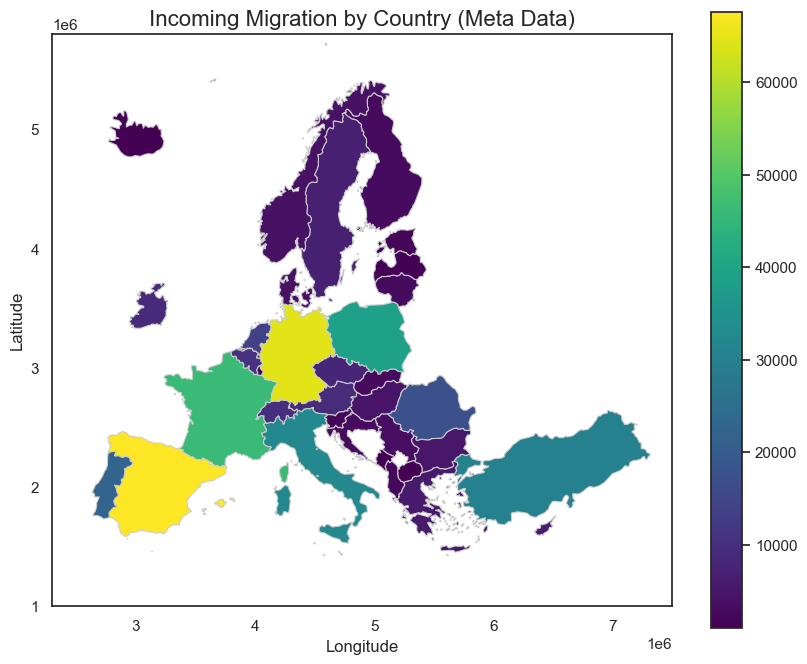

In [54]:
# Set Seaborn style
sns.set_theme(style="white")

# Plot static map
fig, ax = plt.subplots(figsize=(10, 8))
merged.plot(column="x", 
         cmap="viridis", 
         linewidth=0.8, 
         ax=ax, 
         edgecolor="0.8", 
         legend=True)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Set custom ranges
ax.set_xlim([2300000, 7500000])   # X range
ax.set_ylim([1000000, 5800000])   # Y range

ax.set_title("Incoming Migration by Country (Meta Data)", fontsize=16)

# ax.axis("off")
plt.show()

### Interactive Choropleth Map with `Folium`

This map provides an **interactive web-based visualisation** of the same migration dataset.

Features include:
- Zoomable and pannable map (based on `folium.Map`)
- Color scale representing migration values
- Hover tooltips showing:
  - Country name (`geo_name`)
  - Incoming migration count (`x`)
- Exportable as an interactive HTML file

We first reproject the geometries to **WGS84 (EPSG:4326)** for web mapping compatibility.

In [56]:
# Reproject to WGS84 (lat/lon)
merged_wgs84 = merged.to_crs(epsg=4326)

# Make folium map
m = folium.Map(location=[50, 15], zoom_start=4, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=merged_wgs84.to_json(),
    name="choropleth",
    data=merged_wgs84,
    columns=["NUTS_ID", "x"],
    key_on="feature.properties.NUTS_ID",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Incoming Migration (Meta Data)",
).add_to(m)

folium.GeoJson(
    merged_wgs84.to_json(),
    name="Labels",
    style_function=lambda x: {"color": "transparent", "fillOpacity": 0},
    tooltip=folium.features.GeoJsonTooltip(
        fields=["geo_name", "x"],
        aliases=["Country", "Incoming migration"],
        localize=True
    ),
).add_to(m)

folium.LayerControl().add_to(m)

m.save("/Users/wenlanzhang/Downloads/incoming_migration_map.html")

m